# Soy blossom period prediction model

## Setup

### Configure environment

In [0]:
!pip install pydot

### Show the machine details the environment is running on

Show CPU info

In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt arat arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
mode

Show RAM info

In [0]:
!cat /proc/meminfo

MemTotal:       13335204 kB
MemFree:        11239908 kB
MemAvailable:   12657368 kB
Buffers:           44244 kB
Cached:          1548792 kB
SwapCached:            0 kB
Active:           495816 kB
Inactive:        1374508 kB
Active(anon):     256800 kB
Inactive(anon):      324 kB
Active(file):     239016 kB
Inactive(file):  1374184 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1332 kB
Writeback:             0 kB
AnonPages:        277304 kB
Mapped:           154004 kB
Shmem:               840 kB
Slab:             120968 kB
SReclaimable:      92012 kB
SUnreclaim:        28956 kB
KernelStack:        3552 kB
PageTables:         4456 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667600 kB
Committed_AS:    1640532 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

Show GPU info

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 312939216623794097, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10495980708704080951
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4835293293178213036
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281491559
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5461254189511171028
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

### Import modules

In [0]:
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import random

import tensorflow as tf
import keras
from sklearn.metrics import r2_score as r2_metric
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


In [0]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Set up the dataset

Download a dataset from shared Drive folder. 

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1lLemPuEQkL1-OQCPrSbYyMLFAwVlcpyD'})
downloaded.GetContentFile('soydata.csv')

Import data set into pandas dataframe. The dataset contains a missing value on one of the key features the model will be training with, so we need to remove that explicitly

In [0]:
df = pd.read_csv('soydata.csv', index_col=[0, 1], prefix='Experiment')
df.dropna()

The data in now loaded, it uses format that will be described somewhere here some day. 

### Feature extraction

Shuffle the data. As dataset uses multiindex that is a little tricky, we need to shuffle only the certain level, but the days inside a single experiment shall be in natural order.

In [0]:
shuffled_indexes = [i for i in range(len(df.index.levels[0]))]
random.shuffle(shuffled_indexes)
new_indexes = sorted(df.index, key=lambda x: shuffled_indexes.index(x[0]))

In [0]:
df = df.reindex(new_indexes)

Select features and target parameter. As the data is shuffled at this point we no longer need multi-index, and selecting values will truncate that information automatically.

In [0]:
features = ['t_min', 't_max', 'dlen', 'day']
data = df[features].values
target = df['state'].values

data is numpy matrix with only the needed features for the model and target is numpy vector with output data

In [0]:
#@title Select number of rows to display { run: "auto", form-width: "30%" }
num_entries = 3 #@param {type:"slider", min:0, max:5, step:1}
print("Data:  ", data.shape, "Showing only", num_entries, "\n", data[0:num_entries], "\n")
print("Target:", target.shape, "Showing only", num_entries, "\n", target[0:num_entries], "\n")

Data:   (6134, 4) Showing only 3 
 [[0.         0.         0.06527095 0.        ]
 [0.         0.03375    0.13090747 0.02      ]
 [0.         0.055      0.19687751 0.04      ]] 

Target: (6134,) Showing only 3 
 [0.00669285 0.00800223 0.00956532] 



Split the data for training and testing

In [0]:
#@title Set the desired partition of test and train samples { run: "auto", form-width: "30%", display-mode: "both" }
border = 6100 #@param {type:"slider", min:4000, max:6100, step:30}
train_input, train_output = data[:border], target[:border]
test_input, test_output = data[border:], target[border:]

print("Train set contains", len(train_input))
print("Test set contains", len(test_input))

Train set contains 6100
Test set contains 34


##  Model

We will use a simple model with input layer of 4 neurons, a single hidden layer with 20 neurons and 1 output neuron

### Keras model definition

In [0]:
model = keras.Sequential()
model.add(keras.layers.Dense(20, input_dim=4, activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

### Keras model compile

In [0]:
sgd = optimizers.SGD(lr=10.06)

In [0]:
model.compile(loss='mse',
              optimizer=sgd,
              metrics=['mse', 'mae'])

Model summary shows the architecture of the keras model

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
None


## Results

In [0]:
#@title Hyperparameters { run: "auto", form-width: "30%" }
epochs = 15 #@param {type:"integer"}
history = model.fit(
    train_input, train_output,
    epochs=epochs,
    verbose=1,
    batch_size=25,
    validation_split=0.01)

Train on 6039 samples, validate on 61 samples
Epoch 1/15
6039/6039 [==============================] - 2s 265us/step - loss: 0.0306 - mean_squared_error: 0.0306 - mean_absolute_error: 0.0923 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1148
Epoch 2/15
6039/6039 [==============================] - 1s 146us/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0477 - val_loss: 7.2178e-04 - val_mean_squared_error: 7.2178e-04 - val_mean_absolute_error: 0.0238
Epoch 3/15
6039/6039 [==============================] - 1s 138us/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0359 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0855
Epoch 4/15
6039/6039 [==============================] - 1s 135us/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0281 - val_loss: 1.0359e-04 - val_mean_squared_error: 1.0359e-04 - val_mean_absolute_error: 0.0086
Epoch 5/15
6039/60

In [0]:
loss, mse, mae = model.evaluate(test_input, test_output)

print("MSE: ", mse)
print("MAE: ", mae)
# print("R2:  ", r2_value)
print("Loss:", loss)

34/34 [==============================] - 0s 368us/step
MSE:  5.581084277604104e-06
MAE:  0.0018535340752671747
Loss: 5.581084277604104e-06


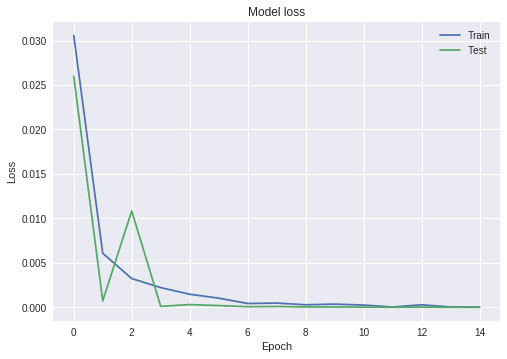

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Save model for future use

Model can be saved and then loaded to work in different environment

In [0]:
model.save('keras-model.h5')

Model stores as serialized executable object, can be loaded and instanciated on the fly to exactly the same model. There are some restrictions on such saving method though. If you use this method you can only use keras api and do not include custom code, metrics for instance, that is a pitty because keras doesn't have a standart R^2 metric implementation, thus cannot be saved to be loaded without recompilation.

In [0]:
del model

In [0]:
from keras.models import load_model

model = load_model('keras-model.h5')

In [0]:
showcase_result_loaded = model.predict(showcase_data)

## Evaluating difference in predicted states on actual blossum dates

Filter data so that it only has dates with actual blossum, 'day' field is defined so that it is calendar dates mapped into [0;1] interval so selecting blossum dates is easy as selecting rows where 'day' == 1 

In [0]:
blossum_dates_dataset = df.loc[df['day'] == 1.0]

In [0]:
predicted_blossum = model.predict(blossum_dates_dataset[features].values)

We can only observe the difference in state, because none of the inputs produce state >= 1, so that it is impossible to observe the difference in days without analytical or numerical extrapolation of model predictive function

In [0]:
diff_state = predicted_blossum - blossum_dates_data['state'].values

In [0]:
diff_state

array([[-0.00533727, -0.00533727, -0.00533727, ..., -0.00533727,
        -0.00533727, -0.00533727],
       [-0.00585678, -0.00585678, -0.00585678, ..., -0.00585678,
        -0.00585678, -0.00585678],
       [-0.00533899, -0.00533899, -0.00533899, ..., -0.00533899,
        -0.00533899, -0.00533899],
       ...,
       [-0.00569686, -0.00569686, -0.00569686, ..., -0.00569686,
        -0.00569686, -0.00569686],
       [-0.00569448, -0.00569448, -0.00569448, ..., -0.00569448,
        -0.00569448, -0.00569448],
       [-0.00568875, -0.00568875, -0.00568875, ..., -0.00568875,
        -0.00568875, -0.00568875]])

In [0]:
print("Mean", np.mean(diff_state))
print("Std", np.std(diff_state))

Mean -0.005612428662835249
Std 0.000289523318887976


In [0]:
print("Mean", np.mean(blossum_dates_data['state']))
print("Std", np.std(blossum_dates_data['state']))

Mean 0.9820137900379083
Std 1.1102230246251565e-16


In ideal case we want the model expected value be exactly equal to actual predicted blossum dates

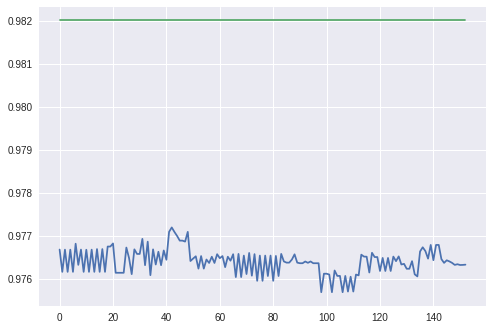

In [0]:
plt.plot([x for x in range(len(predicted_blossum))], predicted_blossum)
plt.plot([x for x in range(len(blossum_dates_data['state'].values))], blossum_dates_data['state'].values)

## Conclusion

The model passed proof of concept phase, it does learn and gives OK prediction, more data will lead to even more accurate results.